In [14]:
# pip install torch torchvision pillow

In [15]:
# pip install transformers

In [5]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

In [6]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ViT input size.
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB.
    transforms.ToTensor(),  # Convert image to tensor.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize tensor values.
])

In [7]:
# Load the Fashion-MNIST dataset
train_data = FashionMNIST(root="./data", train=True, download=True, transform=data_transform)
test_data = FashionMNIST(root="./data", train=False, download=True, transform=data_transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 13260456.03it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273494.63it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5015486.47it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10360977.44it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [8]:
# Split the training data to create a validation set
num_train_examples = int(len(train_data) * 0.8)
num_val_examples = len(train_data) - num_train_examples
train_dataset, val_dataset = random_split(train_data, [num_train_examples, num_val_examples])

In [9]:
# Create Data Loaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [10]:
from transformers import ViTForImageClassification

model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name)

# Classifier to have 10 output classes (for Fashion-MNIST)
model.classifier = torch.nn.Linear(model.classifier.in_features, 10)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [11]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_function = CrossEntropyLoss()

In [12]:
def train(model, train_loader, optimizer, loss_function, epochs=3, device='cuda'):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images).logits
            loss = loss_function(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")

device = "cuda" if torch.cuda.is_available() else "cpu"
train(model, train_loader, optimizer, loss_function, epochs=3, device=device)


Epoch 1/3, Loss: 0.24757813924551011
Epoch 2/3, Loss: 0.12126666101564963
Epoch 3/3, Loss: 0.07345762936833004


In [13]:
def evaluate(model, data_loader, device='cuda'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

evaluate(model, test_loader, device=device)

Accuracy: 94.35%


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9440944014865529
Recall: 0.9434999999999999
F1 Score: 0.9431795661990705


<Figure size 1000x1000 with 0 Axes>

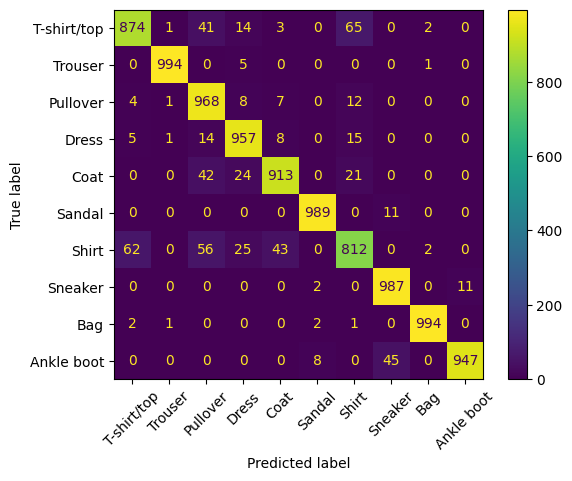

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = FashionMNIST.classes

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
disp.plot(xticks_rotation=45)
plt.show()